# Analysis of varying trimming thresholds of microbial communities of known composition

Script for the analysis and figure generation for 515F/926R 16S and 18S mock communities

In [1]:
#Import libraries in python3 kernel
import pandas as pd
import seaborn as sns
import glob
import os
import sys
from pathlib import Path
#!conda install --yes --prefix {sys.prefix} boto
import boto
import shutil
#!conda install --yes --prefix {sys.prefix} tqdm
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import numpy as np
import skbio
#import fastcluster #this package makes skbio run faster clustermaps but can be tricky with missing values from pairwise comparisons
from functools import reduce
#!conda install --yes --prefix {sys.prefix} biopython
from Bio import SeqIO
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import GC
from biom import load_table
from biom.table import Table
from collections import defaultdict
from collections import Counter
import statistics
import itertools as it
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
from qiime2 import Artifact
import tempfile
import zipfile
import yaml
#!conda install --yes --prefix {sys.prefix} -c etetoolkit ete3 
#!conda install -c bioconda seqkit
#pip install ete3
#conda install -c anaconda pyqt
#from ete3 import Tree, TreeStyle
%matplotlib inline

## Load functions

__consolidate_tables__ creates a dataframe of all the merged feature tables and parameters

In [2]:
# Special thanks to Alex Manuele https://github.com/alexmanuele
def consolidate_tables(community):
    if community == "16S":
        comm_id, comm = '16S', '02-PROKs'
        table_list = glob.glob('{0}/*/03-DADA2d/table.qza'.format(comm+'/intermediate_files/all_trims/'))
        print("Found all 16S tables")
    if community == "18S":
        comm_id, comm = '18S','02-EUKs'
        table_list = glob.glob('{0}/*/08-DADA2/table.qza'.format(comm+'/intermediate_files/all_trims/'))
        print("Found all tables")

    dataframes = []  
    for table_path in table_list:
        with tempfile.TemporaryDirectory() as tempdir:
            #load table, dump contents to tempdir
            table = Artifact.load(table_path)
            #Make sure the tables are all FeatureFrequency type
            assert str(table.type) == 'FeatureTable[Frequency]', "{0}: Expected FeatureTable[Frequency], got {1}".format(table_path, table.type)
            Artifact.extract(table_path, tempdir)
            #get the provenance form the tempdir and format it for DF
            prov = '{0}/{1}/provenance/'.format(tempdir, table.uuid)
            action = yaml.load(open("{0}action/action.yaml".format(prov), 'r'), Loader=yaml.BaseLoader)
            paramlist = action['action']['parameters']
            paramlist.append({'table_uuid': "{}".format(table.uuid)})
            paramdict = {}
            for record in paramlist:
                paramdict.update(record)

            # Get the data into a dataframe
              #Biom data
            df = table.view(pd.DataFrame).unstack().reset_index()
            df.columns = ['feature_id', 'sample_name', 'feature_frequency']
            df['table_uuid'] = ["{}".format(table.uuid)] * df.shape[0]
              #param data
            pdf = pd.DataFrame.from_records([paramdict])
              #merge params into main df
            df = df.merge(pdf, on='table_uuid')


            #I like having these columns as the last three. Makes it more readable
            cols = df.columns.tolist()
            reorder = ['sample_name', 'feature_id', 'feature_frequency']
            for val in reorder:
                cols.append(cols.pop(cols.index(val)))
            df = df[cols]
            df['table_path'] = [table_path] * df.shape[0]
            dataframes.append(df)

    #Stick all the dataframes together
    #outputfile="merged_all_tables.tsv"
    df = pd.concat(dataframes)
    #df.to_csv(comm+'/merged_all_tables.tsv', sep='\t', index=False)
    print("Successfully saved all tables.")
    return df, comm, comm_id

In [3]:
df, comm, comm_id = consolidate_tables('16S')

Found all 16S tables
Success.


__merge_metadata__ adds the metadata to the merged feature tables

In [4]:
def merge_metadata():
    #df = pd.read_csv('02-PROKs/'+'/merged_all_tables.tsv', sep='\t')

    tables = df[['sample_name', 'feature_id', 'feature_frequency']].copy()
    tables.rename(columns={'sample_name':'file'}, inplace=True)
    manifest = pd.read_csv('MANIFEST.tsv', sep='\t')
    manifest['file'] = [s.split('SPOT_USC_2/')[1] for s in manifest['absolute-filepath']]
    manifest['file'] = [s.split('.R')[0] for s in manifest['file']]
    manifest = manifest.drop(columns = ['absolute-filepath', 'direction'])
    manifest.drop_duplicates()
    merged = pd.merge(tables,manifest, on='file')
    merged = merged.drop(columns = ['file'])
    merged = merged.drop_duplicates() 
    print('Set up manifest ...')
    
    metadata = pd.read_csv('METADATA.tsv', sep='\t')
    merged = pd.merge(merged,metadata, on='sample-id')
    merged = merged.replace({'V2': '16S'}, regex=True)
    print('Set up metadata ...')
    
    #merged.to_csv(comm+'/merged_asvs_metadata.tsv', sep = '\t')
    print('Saved merged_asvs_metadata.tsv')
    
    return merged

In [5]:
merged = merge_metadata()

Set up manifest ...
Set up metadata ...
Saved merged_asvs_metadata.tsv


__rename_move_taxonomy__ rename taxonomy

In [6]:
def rename_move_all_taxonomies(comm):
    dr = comm+'/intermediate_files/all_trims'
    if not os.path.isdir(dr):
        for root, dirs, files in os.walk(dr): #rename all taxonomy.tsv by their trimlengths
            for file in files:
                if file == "taxonomy.tsv":
                    spl = root.split("/"); newname = spl[-6]; sup = ("/").join(spl[:-6])
                    shutil.copy(root+"/"+file, sup+"/"+newname+".tsv");# shutil.rmtree(root)
        files = glob.glob('{0}F*R*.tsv'.format(dr))
        os.mkdir(dr)
        for file in files:
            shutil.move(file, dr) #puts all tsvs in new directory with correct names
    print('Renamed all taxonomies.')

In [7]:
rename_move_all_taxonomies(comm)

Renamed all taxonomies.


__pick_metadata__ extracts the features according to the given metadata parameters

In [8]:
def pick_metadata(comm, comm_id, composition, runnumber, R='all', F='all'):
#make df of features/composition+run+comm

    composition = composition
    runnumber = runnumber
    R = R
    F = F

    files = glob.glob('{0}*.tsv'.format(comm+'/intermediate_files/all_taxonomies/'))
    taxos = []
#    if not os.path.exists(path+composition):
#        os.mkdir(path+composition)
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        tax['table_id'] = str(filename.split('/')[-1])
        tax["table_id"] = tax["table_id"].str.replace(".tsv", "")
        tax['Forward_trim'], tax['Reverse_trim'] = tax['table_id'].str.split('R', 1).str
        tax['Forward_trim'] = tax['Forward_trim'].map(lambda x: x.lstrip('F'))
        tax["Forward_trim"] = pd.to_numeric(tax["Forward_trim"])
        tax["Reverse_trim"] = pd.to_numeric(tax["Reverse_trim"])
        taxos.append(tax)
    print('Appended all taxonomies to taxos')
    taxos = pd.concat(taxos)
    taxos = taxos.rename(columns={"Feature ID": "feature_id"}, errors="raise")
    #taxos.to_csv(comm+'/taxos.tsv', sep = '\t')
    separated = merged.merge(taxos, how='left', on='feature_id')
    separated = separated.drop_duplicates()
    separated = separated[separated["community"] == comm_id]
    separated = separated[separated["composition"] == composition]
    separated['run-number']= separated['run-number'].astype(str)
    separated = separated[separated["run-number"] == runnumber]
    separated['total'] = separated.groupby(['table_id','sample-id'])['feature_frequency'].transform('sum')
    separated['ratio'] = separated['feature_frequency']/(separated['total'])
    separated_taxonomies = separated.copy()
    #make a dictionary with keys for id-ing the taxon belonging to this sub-community
    separated_dic = pd.Series(separated.Taxon.values,separated.feature_id.values).to_dict()
    print('Saved separated by metadata dataframe.')
    
    return composition, runnumber, R, F, separated, files

In [35]:
composition, runnumber, R, F, separated, files = pick_metadata(comm, comm_id, 'Even', '46')

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


Appended all taxonomies to taxos
Saved separated by metadata dataframe.


__rename_taxonomies__ extracts zipped classification files from qiime2, renames them by the trimming length used, and moves them to a new folder

In [10]:
def pick_taxonomies(comm, comm_id,  composition, runnumber, files):
#generate folder of split taxonomies by runnumber and composition
    # Directory
    directory = composition+runnumber
    # Parent Directory path
    parent_dir = comm+'/intermediate_files/all_taxonomies'
    # Path
    path = os.path.join(parent_dir, directory)
    # Create the directory
    # 'GeeksForGeeks' in
    # '/home / User / Documents'
    if not os.path.isdir(parent_dir+'/'+directory): 
        os.mkdir(path)
        for filename in files:
            taxonomy = pd.read_csv(filename, sep='\t')
            taxonomy = taxonomy.rename(columns={"Feature ID": "feature_id"}, errors="raise")
            newz = taxonomy.merge(merged, how='left', on='feature_id')
            #new = newz.drop(['sample-id'], axis=1)
            new = newz.drop_duplicates()
            new = new[new["community"] == comm_id]
            new = new[new["composition"] == composition]
            new['run-number']= new['run-number'].astype(str)
            new = new[new["run-number"] == runnumber]
            new = new[new.feature_frequency != 0]
            new = new.rename(columns={"feature_id":"Feature ID"}, errors="raise")
            new = new[['Feature ID', 'Taxon', 'Confidence']].copy()
            new = new.drop_duplicates()
            new = new.set_index('Feature ID')
            d = 'all_taxonomies/'
            if new.empty:
                print('DataFrame from '+ filename +' is empty!')
            else:
                new.to_csv(filename.split(d)[0]+d+composition+runnumber+'/'+runnumber+filename.split(d)[1], sep = '\t')
           
            print('Split taxonomies')
    else:
        print("Taxonomies already split")
    
    return

In [11]:
pick_taxonomies(comm, comm_id, composition, runnumber, files)

Taxonomies already split


__make_fasta__ extracts sequences from zipped qiime2 files, and makes new fasta file for the features from the given metadata parameters

In [12]:
def make_fasta(comm, R, F, composition, runnumber):
    
    fastaoutfilename = comm+'/intermediate_files/all_seqs/allfasta.fasta'
    
    if not os.path.isfile(fastaoutfilename):
        os.mkdir(comm+'/intermediate_files/all_seqs')
        # Get list of all .qza
        repseqs = glob.glob('{0}/*/*/representative_sequences.qza'.format(comm+'/intermediate_files/all_trims'), recursive=True)
        #for i in tqdm
        for repseq in repseqs:
            with zipfile.ZipFile(repseq, 'r') as zipObj:
                # Get a list of all archived file names from the zip
                listOfFileNames = zipObj.namelist()
                # Iterate over the file names
                for fileName in listOfFileNames:
                    # Check filename endswith fasta
                    if fileName.endswith('.fasta'):
                        # Extract a single file from zip
                        zipObj.extract(fileName, 'temp_fasta')
                        
    
        with open(fastaoutfilename, 'wb') as outfile:
            for filename in glob.glob('temp_fasta/*/*/*.fasta'):
                if filename == fastaoutfilename:
                    # don't want to copy the output into the output
                    continue
                with open(filename, 'rb') as readfile:
                    shutil.copyfileobj(readfile, outfile)
        shutil.rmtree('temp_fasta', ignore_errors=False, onerror=None)
    

    if R!='all':
        rallfs = separated[separated.Reverse_trim == R]
        separated_dic = pd.Series(rallfs.Taxon.values,rallfs.feature_id.values).to_dict()
    else:
        separated_dic = pd.Series(separated.Taxon.values, separated.feature_id.values).to_dict()
    if F!='all':
        fallrs = separated[separated.Forward_trim == F]
        separated_dic = pd.Series(fallrs.Taxon.values,fallrs.feature_id.values).to_dict()
    else:
        separated_dic = pd.Series(separated.Taxon.values, separated.feature_id.values).to_dict()

    fa = SeqIO.parse(comm+'/intermediate_files/all_seqs/allfasta.fasta',
                 "fasta")
    seqs_i_want = [] #we'll put the good sequences here
    for record in fa: #a SeqRecord has the accession as record.id, usually.
        if record.id in separated_dic.keys(): #This is how you check if the accession is in the values of the dict
            seqs_i_want.append(record)
    #Now we can write the list of records to a fasta file. This will take care of the formatting etc
    with open(comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'.fasta', "w") as f:
        SeqIO.write(seqs_i_want, f, "fasta")
        
    
    
    return print('Saved selected sequences as '+comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'.fasta')

In [13]:
make_fasta(comm, R, F, composition, runnumber)

Saved selected sequences as 02-PROKs/intermediate_files/all_seqs/RallFall46Staggered.fasta


In [68]:
def make_phylo_tree():
    tax_key = separated[['Taxon', 'feature_id']].copy() #extract columns
    tax_key['key'] = [s.split('; ')[-2:] for s in tax_key['Taxon']] #extract only the last two tax ranks for visualization
    tax_key['key'] = tax_key['key'].apply(lambda x: '_'.join(map(str, x))) #convert list of last two ranks to string
    tax_keys = tax_key.copy()
    tax_keys_dic = pd.Series(tax_keys.key.values,tax_keys.feature_id.values).to_dict() #make into dictionary
    
    with open(comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'.fasta') as original, open(comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'_taxoids.fasta', 'w') as corrected:
        for seq_record in SeqIO.parse(original, 'fasta'):
            if seq_record.id in tax_keys_dic:
                seq_record.id = seq_record.description = tax_keys_dic[seq_record.id]
            SeqIO.write(seq_record, corrected, 'fasta')
            
    ! seqkit rmdup -n < $comm'/intermediate_files/all_seqs/R'$R'F'$F$runnumber$composition'_taxoids.fasta' > out.fa
    
    ! wc -l out.fa
    
    # Read in the file
    with open('out.fa', 'r') as file :
        filedata = file.read()

    # Replace the target strings because misinterpreted by FastTree
    filedata = filedata.replace('(', '[')
    filedata = filedata.replace(')', ']')

    # Write the file out again
    with open('out.fa', 'w') as file:
        file.write(filedata)
    
    ! ~/mafft-mac/mafft.bat out.fa > aligneddedup.fasta
    
    ! ~/FastTree -gtr -nt < aligneddedup.fasta > tree_18stg.nwk
    

In [22]:
expobs_comp['key'] = [s.split('; ')[-2:] for s in expobs_comp['Taxon']] #extract only the last two tax ranks for visualization
expobs_comp['key'] = expobs_comp['key'].apply(lambda x: '_'.join(map(str, x))) #convert list of last two ranks to string
expobs_comp['ratio'] = expobs_comp['ratio'].fillna(0)

In [23]:
separcopy = expobs_comp.copy()
separcopy['Phylum'] = separcopy['Taxon'].str.split('; ').str[1]
separcopy['Phylum'] = separcopy['Phylum'].str.split('p__').str[1]

In [24]:
separcopy[['Staggered_ratio_expected']] = separcopy[['Staggered_ratio_expected']].apply(pd.to_numeric)
separcopy['Type'] = np.where(
    separcopy['Staggered_ratio_expected'] > 0, 'TP', 'FP')

In [25]:
separcopy['Size'] = separcopy['ratio'].copy()
separcopy = separcopy.rename(columns={"key": "ID"})

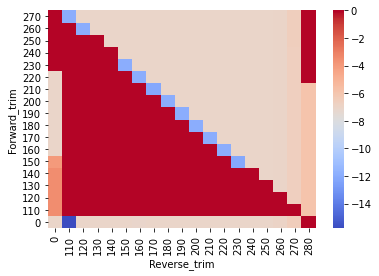

In [379]:
clone = separcopy.loc[separcopy['Clone_name'] == 'OCS155_b (Actino)']
clone = clone[['Forward_trim', 'Reverse_trim', 'Staggered_ratio_expected', 'ratio']]
clone = clone.groupby(['Forward_trim', 'Reverse_trim']).mean()
clone = clone.reset_index()
clone['fold_change'] = clone['ratio']/clone['Staggered_ratio_expected']
clone['log2_fold_change'] = np.log2(clone['fold_change'])
forhm = pd.pivot_table(clone, values= 'log2_fold_change', index='Forward_trim', columns='Reverse_trim')
forhm = forhm.fillna(0)
ax = sns.heatmap(forhm, cmap=sns.color_palette("coolwarm", as_cmap=True))#, cbar=False)
ax.invert_yaxis()
ax.(set_ylim)
fig = ax.get_figure()
fig.savefig(f'outputs/{comm_id}{composition}{runnumber}OCS155_b_Actino.png',
            bbox_inches = "tight")

In [45]:
clonenames = separcopy.Clone_name.unique().tolist()

In [46]:
newsi = [clonename.replace(' ', '_') for clonename in clonenames]
newsi = [clonename.replace('(', '') for clonename in newsi]
newsi = [clonename.replace(')', '') for clonename in newsi]

In [47]:
newsi

['Euryarchaea_MGII',
 'SAR11_Surface_1_Alpha',
 'Thaumarchaea_MGI_a',
 'Flavobacteria',
 'SAR202_a_Chloroflexi',
 'Prochlorococcus',
 'Planctomyces',
 'OCS155_a_Actino',
 'OCS155_b_Actino',
 'Marine_Group_A_aka_SAR406',
 'SAR86_a_Gamma',
 'SAR116_a_Alpha',
 'AEGEAN-169_Alpha',
 'SAR116_b_Alpha',
 'Flavobacteria_Formosa',
 'SAR92_Gamma',
 'Pseudospirillum_Gamma',
 'Thaumarchaea_MGI_b',
 'Flavobacteria_NS9',
 'Rhodobacteriaceae_Alpha',
 'SAR86_b_Gamma',
 'Verrucomicrobia',
 'SAR86_c_Gamma',
 'Flavobacteria_NS5',
 'SAR86_d_Gamma',
 'SAR116_c_Alpha',
 'False_positive',
 'SAR202_b_Chloroflexi']

In [340]:
dat1 = separcopy[['ID', 'Phylum', 'Type', 'ratio']].copy()

In [341]:
dat1 = dat1.drop_duplicates()

In [342]:
dat1 = dat1.fillna('Unknown')

In [343]:
dat1.to_csv('dat1.csv', index_label=False)

In [105]:
dat1.Phylum.unique()

array(['Thermoplasmatota', 'Proteobacteria', 'Crenarchaeota',
       'Bacteroidota', 'Chloroflexi', 'Cyanobacteria', 'Planctomycetota',
       'Actinobacteriota', 'Marinimicrobia_(SAR406_clade)',
       'Verrucomicrobiota', 'Firmicutes', 'Unknown'], dtype=object)

In [216]:
separcopy240 = separcopy.loc[separcopy['Reverse_trim'] == 240]

In [217]:
dat2 = separcopy240[['ID', 'Forward_trim', 'ratio']].copy()

In [220]:
dat2 = dat2.groupby(['ID', 'Forward_trim']).mean()

In [224]:
dat2 = dat2.drop_duplicates()

In [222]:
reset_df = dat2.reset_index()

In [225]:
reset_df["Forward_trim"].replace({0: 280}, inplace=True)

In [226]:
reset_df.to_csv('dat2.csv',index_label=False)

In [227]:
forhm = pd.pivot_table(reset_df, values= 'ratio', index='ID', columns='Forward_trim')

In [231]:
forhm=forhm.fillna(0)

In [233]:
forhm

Forward_trim,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280
ID,,,,,,,,,,,,,,,
f__Actinomarinaceae_g__Candidatus_Actinomarina,0.000000,0.000686,0.000686,0.000686,0.000686,0.000686,0.000686,0.000686,0.000686,0.000686,0.000686,0.000686,0.000686,0.000686,0.000686
f__Clade_I_g__Clade_Ia,0.000000,0.002801,0.002801,0.002801,0.002801,0.002801,0.002801,0.002801,0.002801,0.002801,0.002801,0.002801,0.002801,0.002801,0.002801
f__Cyanobiaceae_g__Prochlorococcus_MIT9313,0.000000,0.000477,0.000477,0.000477,0.000477,0.000477,0.000477,0.000477,0.000477,0.000477,0.000477,0.000477,0.000477,0.000477,0.000477
f__Flavobacteriaceae_g__Formosa,0.000000,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103,0.000103
f__Flavobacteriaceae_g__NS2b_marine_group,0.000000,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211
f__Flavobacteriaceae_g__NS5_marine_group,0.000000,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037
f__Marine_Group_II_g__Marine_Group_II,0.000000,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159
f__Nitrosopumilaceae_g__Candidatus_Nitrosopumilus,0.000000,0.001326,0.001326,0.001326,0.001326,0.001326,0.001326,0.001326,0.001326,0.001326,0.001326,0.001326,0.001326,0.001326,0.001326
f__Nitrosopumilaceae_g__Nitrosopumilaceae,0.000000,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105


In [232]:
forhm.to_csv('tree_hm.csv',index_label=False)

In [344]:
dat3 = separcopy[['ID', 'Staggered_ratio_expected', 'Clone_name']].copy()

In [345]:
dat3 = dat3.drop_duplicates()

In [346]:
dat3

,ID,Staggered_ratio_expected,Clone_name
0,f__Gonyaulacales_g__Neoceratium,0.0005,Dinophyta; Dinophyceae; Neoceratium
2502,g__Guinardia_s__Guinardia_striata,0.1200,Ochrophyta; Bacillariophyta; Coscinodiscophyce...
5855,p__Dinoflagellata_c__Dinophyceae,0.0700,Dinophyta; Dinophyceae; Gyrodinium
5856,p__Dinoflagellata_c__Dinophyceae,0.0700,Diphyta; Dinophyceae; Gymnodinium
15607,f__RAD_B_g__RAD_B,0.0500,Dinophyta; Syndiniales; Dino-Group-I
...,...,...,...
69699,g__uncultured_s__uncultured_marine,0.0000,False positive
69701,d__Eukaryota_p__Ochrophyta,0.0000,False positive
69709,p__Ochrophyta_c__Chrysophyceae,0.0000,False positive
69713,g__Biecheleria_s__Biecheleria_brevisulcata,0.0000,False positive


In [347]:
dat3 = dat3.rename(columns={'Staggered_ratio_expected':'Expected'})

In [348]:
dat3.to_csv('dat3.csv',index_label=False)

In [153]:
dat2

,ID,Forward_trim,ratio,Replicate
95,f__Marine_Group_II_g__Marine_Group_II,240,9.415258e-05,R46-16SS-1
96,f__Marine_Group_II_g__Marine_Group_II,250,9.415258e-05,R46-16SS-1
103,f__Marine_Group_II_g__Marine_Group_II,0,9.414427e-05,R46-16SS-1
148,f__Marine_Group_II_g__Marine_Group_II,230,9.415778e-05,R46-16SS-1
149,f__Marine_Group_II_g__Marine_Group_II,220,9.414376e-05,R46-16SS-1
...,...,...,...,...
802397,g__NS5_marine_group_s__uncultured_marine,180,0.000000e+00,R46-16SS-2
802404,f__SAR116_clade_g__SAR116_clade,180,0.000000e+00,R46-16SS-1
802431,f__SAR116_clade_g__SAR116_clade,180,0.000000e+00,R46-16SS-2
802652,g__Marine_Group_II_s__unidentified_archaeon,190,6.855082e-07,R46-16SS-1


In [39]:
separated['key'] = [s.split('; ')[-2:] for s in separated['Taxon']] #extract only the last two tax ranks for visualization
separated['key'] = separated['key'].apply(lambda x: '_'.join(map(str, x))) #convert list of last two ranks to string
separated['ratio'] = separated['ratio'].fillna(0)
separated.key.unique()

In [ ]:
#determine the top reverse trim by doing
testcopy.sort_values("r2")
goodscores = testcopy.loc[(testcopy['r2'] >= 0.60)]

In [51]:
separated0 = separated.loc[separated['Reverse_trim'] == 0]

In [52]:
separated0.key.unique()

array(['f__Clade_I_g__Clade_Ia',
       'f__Nitrosopumilaceae_g__Candidatus_Nitrosopumilus',
       'f__Flavobacteriaceae_g__NS2b_marine_group',
       'f__SAR202_clade_g__SAR202_clade',
       'f__Cyanobiaceae_g__Prochlorococcus_MIT9313',
       'g__Blastopirellula_s__uncultured_Pirellula',
       'f__Actinomarinaceae_g__Candidatus_Actinomarina',
       'g__Marinimicrobia_(SAR406_clade)_s__unidentified_marine',
       'g__SAR86_clade_s__Rhodobacteraceae_bacterium',
       'g__SAR116_clade_s__alpha_proteobacterium',
       'f__Marine_Group_II_g__Marine_Group_II',
       'g__AEGEAN-169_marine_group_s__metagenome',
       'f__SAR116_clade_g__Candidatus_Puniceispirillum',
       'f__Flavobacteriaceae_g__Formosa',
       'f__Porticoccaceae_g__SAR92_clade',
       'f__Pseudohongiellaceae_g__Pseudohongiella',
       'f__Nitrosopumilaceae_g__Nitrosopumilaceae',
       'g__NS9_marine_group_s__marine_metagenome',
       'f__Rhodobacteraceae_g__uncultured',
       'g__SAR86_clade_s__uncultured_b

In [53]:
separated0_R1 = separated0.loc[separated0['sample-id'] == 'R46-16SS-1']

In [55]:
forhm = pd.pivot_table(separated0_R1, values= 'ratio', index='key', columns='Forward_trim')

In [59]:
forhm = forhm.fillna(0)

In [60]:
forhm.to_csv('testons_ggplot.csv')

In [61]:
forhm

Forward_trim,0,110,120,130,140,150,160,170,180,190,200,210,220
key,,,,,,,,,,,,,
f__Actinomarinaceae_g__Candidatus_Actinomarina,0.000613,0.007812,0.007812,0.007812,0.007812,5.344076e-03,0.000613,6.102060e-04,0.000613,0.000613,0.000613,0.000613,0.000613
f__Clade_I_g__Clade_Ia,0.002551,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.002507,2.521185e-03,0.002521,0.002521,0.002521,0.002536,0.002536
f__Clade_I_g__uncultured,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
f__Cyanobiaceae_g__Prochlorococcus_MIT9313,0.000481,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000472,4.720514e-04,0.000472,0.000472,0.000472,0.000472,0.000481
f__Flavobacteriaceae_g__Formosa,0.000094,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000094,9.383933e-05,0.000094,0.000094,0.000094,0.000094,0.000094
f__Flavobacteriaceae_g__NS2b_marine_group,0.000199,0.000000,0.000000,0.000000,0.000000,9.101550e-07,0.000199,1.994839e-04,0.000199,0.000199,0.000199,0.000199,0.000199
f__Flavobacteriaceae_g__NS5_marine_group,0.000032,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000032,3.127548e-05,0.000031,0.000032,0.000032,0.000032,0.000032
f__Halieaceae_g__OM60(NOR5)_clade,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
f__Marine_Group_II_g__Marine_Group_II,0.000145,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000145,1.447900e-04,0.000145,0.000145,0.000145,0.000145,0.000145


In [62]:
separated

,feature_id,feature_frequency,sample-id,run-number,community,composition,Taxon,Confidence,table_id,Forward_trim,Reverse_trim,sum,ratio,key
1830828,7535a6f86c75377513222e9f08c2de30,0.0,R46-16SS-1,46,16S,Staggered,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,1.000000,F150R80,150,80,0.0,0.000000,f__Marine_Group_II_g__Marine_Group_II
1830829,7535a6f86c75377513222e9f08c2de30,0.0,R46-16SS-1,46,16S,Staggered,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,1.000000,F160R110,160,110,0.0,0.000000,f__Marine_Group_II_g__Marine_Group_II
1830830,7535a6f86c75377513222e9f08c2de30,0.0,R46-16SS-1,46,16S,Staggered,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,1.000000,F140R90,140,90,0.0,0.000000,f__Marine_Group_II_g__Marine_Group_II
1830831,7535a6f86c75377513222e9f08c2de30,0.0,R46-16SS-1,46,16S,Staggered,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,1.000000,F150R40,150,40,0.0,0.000000,f__Marine_Group_II_g__Marine_Group_II
1830832,7535a6f86c75377513222e9f08c2de30,0.0,R46-16SS-1,46,16S,Staggered,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,1.000000,F140R140,140,140,0.0,0.000000,f__Marine_Group_II_g__Marine_Group_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2559294,06ad8aee2710d4b77d4121a90e32bfb7,137.0,R46-16SS-2,46,16S,Staggered,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999983,F0R150,0,150,3671911.0,0.000037,f__Flavobacteriaceae_g__NS5_marine_group
2559295,06ad8aee2710d4b77d4121a90e32bfb7,137.0,R46-16SS-2,46,16S,Staggered,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999983,F250R190,250,190,3672080.0,0.000037,f__Flavobacteriaceae_g__NS5_marine_group
2559296,06ad8aee2710d4b77d4121a90e32bfb7,137.0,R46-16SS-2,46,16S,Staggered,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999983,F240R190,240,190,3672080.0,0.000037,f__Flavobacteriaceae_g__NS5_marine_group
2559297,06ad8aee2710d4b77d4121a90e32bfb7,137.0,R46-16SS-2,46,16S,Staggered,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999983,F250R230,250,230,3670893.0,0.000037,f__Flavobacteriaceae_g__NS5_marine_group


In [ ]:
dat1 = 

In [15]:
#for the #sequences retained per taxa

In [204]:
#make function for building the tree heatmap here

__phylo_tree__ makes an alignment, then a phylogenetic tree from the sequences of all the ASVs selected

__make_tbd_hm__ makes a heatmap showing the taxonomic beta diversity of each trim length combination against the expected community. TBD is a dissimilarity index based on taxonomic trees between two samples where 1 is completely different, and 0 is the completely the same.

In [14]:
def make_tbd_hm(comm, composition, runnumber, level=7):
    
    if not os.path.isdir('Bacaros_Beta'):
        ! git clone https://github.com/alexmanuele/Bacaros_Beta.git
        print("Bacaros Beta was cloned.")
    else:
        print("Bacaros Beta is already cloned.")
    
    #Move the expected community to the taxonomies folder for comparison
    dest_dir = comm+'/intermediate_files/all_taxonomies/'+composition+runnumber
    
    for file in glob.glob('in-silico-mocks/'+comm+'/'+composition+r'/*/data/taxonomy.tsv'):
        print(file+' was moved.')
        shutil.copy(file, os.path.join(dest_dir, 'expected.tsv'))
        
    tax_list = glob.glob('{0}/*.tsv'.format(comm+'/intermediate_files/all_taxonomies/'+composition+runnumber))
    textfile = open("tax_comp.txt", "w")
    for element in tax_list:
        textfile.write(element + "\n")
    textfile.close()
    print("Saved all taxonomies list as tax_comp.txt")

    if not os.path.isdir(dest_dir+'/TBD1'):
        for i in range(1, 8):
            output_dir = 'TBD'+str(i)
            os.mkdir(output_dir)
            ! python Bacaros_Beta/run_beta.py --input tax_comp.txt --metric t --l $i --output $output_dir
            shutil.move(output_dir, dest_dir)
    else:
        print("BTD Already ran")
        
    bacaros_dm = pd.read_csv(dest_dir+'/TBD'+str(level)+'/tax_comp.csv')
    bacaros_dm = bacaros_dm.set_index('Unnamed: 0')
    #bacaros_dm = 1  - bacaros_dm
    #bacaros_dm is a distance matrix of table X table
    #my_pcoa = skbio.stats.ordination.pcoa(bacaros_dm.values)
    #plt.scatter(my_pcoa.samples['PC1'],  my_pcoa.samples['PC2'])
    against_exp = bacaros_dm[['expected']].copy()
    against_exp = against_exp.reset_index().rename(columns={against_exp.index.name:'sample_name'})
    against_exp.drop(against_exp.index[against_exp['sample_name'] == 'expected'], inplace=True)
    against_exp['Forward_trim'] = [s.split('R')[0] for s in against_exp['sample_name']]
    against_exp['Forward_trim'] = [s.split(runnumber+'F')[1] for s in against_exp['Forward_trim']]
    against_exp['Reverse_trim'] = [s.split('R')[1] for s in against_exp['sample_name']]
    against_exp["Forward_trim"] = pd.to_numeric(against_exp["Forward_trim"])
    against_exp["Reverse_trim"] = pd.to_numeric(against_exp["Reverse_trim"])
    against_exp["Forward_trim"].replace({0: 280}, inplace=True)
    against_exp["Reverse_trim"].replace({0: 290}, inplace=True)
    tohm = against_exp.pivot("Forward_trim", "Reverse_trim", "expected")
    tohm.rename({280: 'full'}, axis=0, inplace=True)
    tohm.rename({290: 'full'}, axis=1, inplace=True)
    ax = sns.heatmap(tohm, cmap=sns.color_palette("coolwarm", as_cmap=True), vmin=0, vmax=1)
    ax.invert_yaxis()
    #plt.figure(figsize=(12,12))
    fig = ax.get_figure()
    fig.savefig(f'outputs/{comm_id}{composition}{runnumber}{level}bacaros.png',
                bbox_inches = "tight")
    
    # get max and min values
    #print('The min value is {0} and the max value is {1}'.format(df.at[df.stack().index[np.argmin(df.values)]], 
    #                                                             minv = df.at[df.stack().index[np.argmax(df.values)]]))

    return tohm, dest_dir

Bacaros Beta is already cloned.
in-silico-mocks/02-PROKs/Even/ecf50974-658a-412a-a348-d2882b7da8f7/data/taxonomy.tsv was moved.
Saved all taxonomies list as tax_comp.txt
BTD Already ran


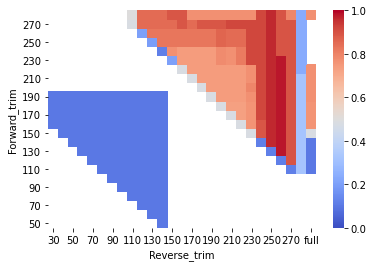

In [36]:
tohm, dest_dir = make_tbd_hm(comm, composition, runnumber, level='7')

In [37]:
#calculate the min length of reads that lead to a result and make a presence absence

__r2_plot__ makes a linear regression of the observed relative abundances of each combination of trim lengths against the expected, and plots each coefficient of determination in a heatmap

In [38]:
## to import the expected taxonomies and transofrm to ratios
def expected_df(comm, composition):
    expected_silva = pd.read_csv('in-silico-mocks/'+comm+'/expected.tsv', sep='\t')
    expected_silva_selected = expected_silva.loc[~((expected_silva[composition+'_percent_expected'] == 0))]
    expected_silva_selected[composition+'_ratio_expected'] = expected_silva_selected[composition+'_percent_expected']/(expected_silva_selected[composition+'_percent_expected'].sum())
    ax = sns.barplot(x=composition+"_ratio_expected", y="Clone_name", data=expected_silva_selected, saturation=.5)
    ax.set(xlabel='Relative abundance', ylabel='Group')
    #ax.bar_label(ax.containers[0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.figure.savefig(comm+composition+'_expected.png', bbox_inches='tight')
    fig = ax.get_figure()
    fig.savefig('outputs/'+comm+composition+'_expected.png', bbox_inches = "tight")

        
    #make r2 fig
    expobs_comp = separated.merge(expected_silva_selected, on='Taxon', how='outer')
    expobs_comp = expobs_comp.fillna(0)
    expobs_comp["Clone_name"].replace({0: "False positive"}, inplace=True)
    grouped = expobs_comp.groupby(['Forward_trim', 'Reverse_trim'])
    test = (grouped.apply(lambda x: pd.Series(stats.linregress(x[composition+'_ratio_expected'], x['ratio'])))
               .rename(columns={
                        0: 'slope',
                        1: 'intercept',
                        2: 'rvalue',
                        3: 'pvalue',
                        4: 'stderr'}))
    test['r2'] = test['rvalue']**2
    testcopy = test.reset_index()
    testcopy["Forward_trim"].replace({0: 300}, inplace=True) #0 trim length translates to no trimming, so max read length
    testcopy["Reverse_trim"].replace({0: 300}, inplace=True)
    tohm = testcopy.pivot("Forward_trim", "Reverse_trim", "r2")
    tohm.fillna(0)
    ax = sns.heatmap(tohm,cmap=("coolwarm"), vmin=0, vmax=1)
    ax.invert_yaxis()
    #plt.figure(figsize=(12,12))
    ax.set(xlabel='Reverse trim length', ylabel='Forward trim length')
    fig = ax.get_figure()
    fig.savefig('outputs/'+comm_id+composition+runnumber+'_r2.png', bbox_inches = "tight")


    return expected_silva_selected, testcopy, expobs_comp

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm


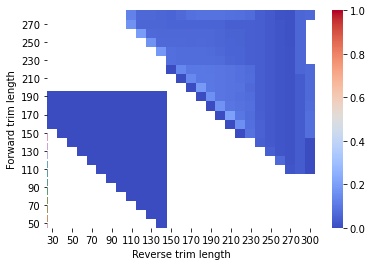

In [39]:
expected_silva_selected, testcopy, expobs_comp = expected_df(comm, composition)

In [58]:
false_positives = expobs_comp[expobs_comp["Clone_name"] == 'False positive']

In [59]:
false_positives_new = false_positives[false_positives.feature_frequency != 0]

In [55]:
false_positives_new.sort_values('ratio')

,feature_id,feature_frequency,sample-id,run-number,community,composition,Taxon,Confidence,table_id,Forward_trim,Reverse_trim,total,ratio,Unnamed: 0,Feature ID,Staggered_percent_expected,Even_percent_expected,Clone_name,New_Taxon,Even_ratio_expected
455444,07593ecdf1fba9b480acb31e6af0f89f,2.0,R46-16SE-1,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.985147,F220R180,220,180,5008524.0,3.993192e-07,0.0,0,0.0,0.0,False positive,0,0.0
455424,07593ecdf1fba9b480acb31e6af0f89f,2.0,R46-16SE-1,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.985147,F210R180,210,180,5008524.0,3.993192e-07,0.0,0,0.0,0.0,False positive,0,0.0
455429,07593ecdf1fba9b480acb31e6af0f89f,2.0,R46-16SE-1,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.985147,F220R170,220,170,5008524.0,3.993192e-07,0.0,0,0.0,0.0,False positive,0,0.0
455432,07593ecdf1fba9b480acb31e6af0f89f,2.0,R46-16SE-1,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.985147,F220R210,220,210,5008524.0,3.993192e-07,0.0,0,0.0,0.0,False positive,0,0.0
455450,07593ecdf1fba9b480acb31e6af0f89f,2.0,R46-16SE-1,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.985147,F200R200,200,200,5008524.0,3.993192e-07,0.0,0,0.0,0.0,False positive,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446615,b079d9bfa3d84b0bdc2c1398d247150e,14.0,R46-16SE-2,46,16S,Even,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.986491,F270R280,270,280,664272.0,2.107570e-05,0.0,0,0.0,0.0,False positive,0,0.0
446614,b079d9bfa3d84b0bdc2c1398d247150e,14.0,R46-16SE-2,46,16S,Even,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.986491,F260R280,260,280,664272.0,2.107570e-05,0.0,0,0.0,0.0,False positive,0,0.0
446733,b079d9bfa3d84b0bdc2c1398d247150e,14.0,R46-16SE-2,46,16S,Even,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.986491,F230R280,230,280,664272.0,2.107570e-05,0.0,0,0.0,0.0,False positive,0,0.0
446732,b079d9bfa3d84b0bdc2c1398d247150e,14.0,R46-16SE-2,46,16S,Even,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.986491,F220R280,220,280,664272.0,2.107570e-05,0.0,0,0.0,0.0,False positive,0,0.0


__make_fold_change_plots__ makes a heatmap of the log2 fold change for all expected groups

In [54]:
def make_fold_change_plots(expobs_comp, composition):
    #add the keys to expobs for matching with the tree tip labels
    expobs_comp['key'] = [s.split('; ')[-2:] for s in expobs_comp['Taxon']] #extract only the last two tax ranks for visualization
    expobs_comp['key'] = expobs_comp['key'].apply(lambda x: '_'.join(map(str, x))) #convert list of last two ranks to string
    expobs_comp['ratio'] = expobs_comp['ratio'].fillna(0)
    
    separcopy = expobs_comp.copy()
    separcopy['Phylum'] = separcopy['Taxon'].str.split('; ').str[1]
    separcopy['Phylum'] = separcopy['Phylum'].str.split('p__').str[1]
    
    separcopy[[composition+'_ratio_expected']] = separcopy[[composition+'_ratio_expected']].apply(pd.to_numeric)
    separcopy['Type'] = np.where(
        separcopy[composition+'_ratio_expected'] > 0, 'TP', 'FP')
    
    separcopy['Size'] = separcopy['ratio'].copy()
    separcopy = separcopy.rename(columns={"key": "ID"})
    
    clonenames = separcopy.Clone_name.unique().tolist()
    clonenames_id = [clonename.replace(' ', '_') for clonename in clonenames]
    clonenames_id = [clonename.replace('(', '') for clonename in clonenames_id]
    clonenames_id = [clonename.replace(')', '') for clonename in clonenames_id]
    
    for clonename in clonenames:
        clone = separcopy.loc[separcopy['Clone_name'] == clonename]
        clone = clone[['Forward_trim', 'Reverse_trim', composition+'_ratio_expected', 'ratio']]
        clone = clone.groupby(['Forward_trim', 'Reverse_trim']).mean()
        clone = clone.reset_index()
        clone['fold_change'] = clone['ratio']/clone[composition+'_ratio_expected']
        clone['log2_fold_change'] = np.log2(clone['fold_change'])
        forhm = pd.pivot_table(clone, values= 'log2_fold_change', index='Forward_trim', columns='Reverse_trim')
        forhm = forhm.fillna(0)
        ax = sns.heatmap(forhm, cmap=sns.color_palette("coolwarm", as_cmap=True))#, cbar=False)
        ax.invert_yaxis()
        fig = ax.get_figure()
        fig.savefig(f'outputs/{comm_id}{composition}{runnumber}{clonename}.png',
                    bbox_inches = "tight")
        plt.clf()


In [55]:
make_fold_change_plots(expobs_comp, composition)

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)

<Figure size 432x288 with 0 Axes>

In [64]:
testcopy.sort_values('r2')

,Forward_trim,Reverse_trim,slope,intercept,rvalue,pvalue,stderr,r2
161,180,90,NaN,NaN,0.000000,1.000000e+00,0.000000,0.000000
112,160,30,NaN,NaN,0.000000,1.000000e+00,0.000000,0.000000
113,160,40,NaN,NaN,0.000000,1.000000e+00,0.000000,0.000000
114,160,50,NaN,NaN,0.000000,1.000000e+00,0.000000,0.000000
115,160,60,NaN,NaN,0.000000,1.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...
271,240,280,0.020312,-0.000044,0.776250,1.374486e-140,0.000628,0.602565
304,260,280,0.020312,-0.000044,0.776250,1.374486e-140,0.000628,0.602565
242,220,280,0.020312,-0.000044,0.776250,1.374486e-140,0.000628,0.602565
322,270,280,0.020312,-0.000044,0.776250,1.374486e-140,0.000628,0.602565


In [60]:
false_positives_new['ratios_to_plots'] = false_positives_new.groupby(['table_id', 'sample-id'])['feature_frequency'].transform('sum')

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
false_positives_new = false_positives_new.groupby(['table_id', 'sample-id']).mean('sum')

In [65]:
false_positives_new

feature_frequency  Confidence  Forward_trim  \
table_id sample-id                                                 
F0R0     R46-16SE-1           7.647059    0.981349             0   
         R46-16SE-2          10.931034    0.910192             0   
F0R110   R46-16SE-1           8.461538    0.987729             0   
         R46-16SE-2          11.052632    0.893137             0   
F0R120   R46-16SE-1           7.933333    0.981541             0   
...                                ...         ...           ...   
F270R260 R46-16SE-2          11.500000    0.986491           270   
F270R270 R46-16SE-1           9.500000    0.986491           270   
         R46-16SE-2          11.500000    0.986491           270   
F270R280 R46-16SE-1           9.500000    0.986491           270   
         R46-16SE-2          11.500000    0.986491           270   

                     Reverse_trim      total     ratio  Unnamed: 0  \
table_id sample-id                                                   
F0R0     R46-16SE-1             0  5008516.0  0.000002         0.0   
         R46-16SE-2             0  3561127.0  0.000003         0.0   
F0R110   R46-16SE-1           110  1959415.0  0.000004         0.0   
         R46-16SE-2           110  1418054.0  0.000008         0.0   
F0R120   R46-16SE-1           120  5004076.0  0.000002         0.0   
...                           ...        ...       ...         ...   
F270R260 R46-16SE-2           260  3252439.0  0.000004         0.0   
F270R270 R46-16SE-1           270  4606455.0  0.000002         0.0   
         R46-16SE-2           270  3252439.0  0.000004         0.0   
F270R280 R46-16SE-1           280   867259.0  0.000011         0.0   
         R46-16SE-2           280   664272.0  0.000017         0.0   

                     Staggered_percent_expected  Even_percent_expected  \
table_id sample-id                                                       
F0R0     R46-16SE-1                         0.0                    0.0   
         R46-16SE-2                         0.0                    0.0   
F0R110   R46-16SE-1                         0.0                    0.0   
         R46-16SE-2                         0.0                    0.0   
F0R120   R46-16SE-1                         0.0                    0.0   
...                                         ...                    ...   
F270R260 R46-16SE-2                         0.0                    0.0   
F270R270 R46-16SE-1                         0.0                    0.0   
         R46-16SE-2                         0.0                    0.0   
F270R280 R46-16SE-1                         0.0                    0.0   
         R46-16SE-2                         0.0                    0.0   

                     Even_ratio_expected  ratios_to_plots  
table_id sample-id                                         
F0R0     R46-16SE-1                  0.0         0.000026  
         R46-16SE-2                  0.0         0.000089  
F0R110   R46-16SE-1                  0.0         0.000056  
         R46-16SE-2                  0.0         0.000148  
F0R120   R46-16SE-1                  0.0         0.000024  
...                                  ...              ...  
F270R260 R46-16SE-2                  0.0         0.000021  
F270R270 R46-16SE-1                  0.0         0.000008  
         R46-16SE-2                  0.0         0.000021  
F270R280 R46-16SE-1                  0.0         0.000044  
         R46-16SE-2                  0.0         0.000104  

[362 rows x 11 columns]

In [66]:
expobs_comp_copy = expobs_comp.copy()

In [67]:
expobs_comp_copy['sums'] = expobs_comp_copy.groupby(['table_id','sample-id','Clone_name']).transform('sum')

ValueError: Wrong number of items passed 17, placement implies 1

In [42]:
expobs_comp_copy['ratios_to_plot'] = expobs_comp_copy.loc[expobs_comp_copy['Clone_name'] == 'False positive'].sum()

In [49]:
expobs_comp.sort_values('ratio')

,feature_id,feature_frequency,sample-id,run-number,community,composition,Taxon,Confidence,table_id,Forward_trim,Reverse_trim,total,ratio,Unnamed: 0,Feature ID,Staggered_percent_expected,Even_percent_expected,Clone_name,New_Taxon,Even_ratio_expected
456124,e645ead796d466e338a044618a625859,0.0,R46-16SE-2,46,16S,Even,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,0.756981,F130R260,130,260,3559977.0,0.0,0.0,0,0.0,0.0,False positive,0,0.000000
442832,4e446a437f4b70fae13651fd0593ca2e,0.0,R46-16SE-1,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.757806,F190R220,190,220,5008518.0,0.0,0.0,0,0.0,0.0,False positive,0,0.000000
442831,4e446a437f4b70fae13651fd0593ca2e,0.0,R46-16SE-1,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.757806,F180R220,180,220,5008518.0,0.0,0.0,0,0.0,0.0,False positive,0,0.000000
442830,4e446a437f4b70fae13651fd0593ca2e,0.0,R46-16SE-1,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.757806,F220R160,220,160,360606.0,0.0,0.0,0,0.0,0.0,False positive,0,0.000000
442829,4e446a437f4b70fae13651fd0593ca2e,0.0,R46-16SE-1,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.757806,F220R200,220,200,5008524.0,0.0,0.0,0,0.0,0.0,False positive,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,8f32800b2aaddf64b12980a1b10aaa77,4.0,R46-16SE-1,46,16S,Even,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.999999,F190R40,190,40,4.0,1.0,12.0,da07e0bdc7e0157a11ff2d7fe909ffecd65012b2,1.8,10.0,Euryarchaea MGII,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.090909
967,8f32800b2aaddf64b12980a1b10aaa77,4.0,R46-16SE-1,46,16S,Even,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.999999,F190R100,190,100,4.0,1.0,12.0,da07e0bdc7e0157a11ff2d7fe909ffecd65012b2,1.8,10.0,Euryarchaea MGII,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.090909
966,8f32800b2aaddf64b12980a1b10aaa77,4.0,R46-16SE-1,46,16S,Even,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.999999,F190R80,190,80,4.0,1.0,12.0,da07e0bdc7e0157a11ff2d7fe909ffecd65012b2,1.8,10.0,Euryarchaea MGII,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.090909
964,8f32800b2aaddf64b12980a1b10aaa77,4.0,R46-16SE-1,46,16S,Even,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.999999,F190R50,190,50,4.0,1.0,12.0,da07e0bdc7e0157a11ff2d7fe909ffecd65012b2,1.8,10.0,Euryarchaea MGII,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.090909


In [70]:
expobs_comp_copy

,feature_id,feature_frequency,sample-id,run-number,community,composition,Taxon,Confidence,table_id,Forward_trim,Reverse_trim,total,ratio,Unnamed: 0,Feature ID,Staggered_percent_expected,Even_percent_expected,Clone_name,New_Taxon,Even_ratio_expected
0,7535a6f86c75377513222e9f08c2de30,4.0,R46-16SE-1,46,16S,Even,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,1.000000,F150R80,150,80,9.0,0.444444,12.0,da07e0bdc7e0157a11ff2d7fe909ffecd65012b2,1.8,10.0,Euryarchaea MGII,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.090909
1,7535a6f86c75377513222e9f08c2de30,4.0,R46-16SE-1,46,16S,Even,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,1.000000,F160R110,160,110,9.0,0.444444,12.0,da07e0bdc7e0157a11ff2d7fe909ffecd65012b2,1.8,10.0,Euryarchaea MGII,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.090909
2,7535a6f86c75377513222e9f08c2de30,4.0,R46-16SE-1,46,16S,Even,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,1.000000,F140R90,140,90,9.0,0.444444,12.0,da07e0bdc7e0157a11ff2d7fe909ffecd65012b2,1.8,10.0,Euryarchaea MGII,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.090909
3,7535a6f86c75377513222e9f08c2de30,4.0,R46-16SE-1,46,16S,Even,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,1.000000,F150R40,150,40,9.0,0.444444,12.0,da07e0bdc7e0157a11ff2d7fe909ffecd65012b2,1.8,10.0,Euryarchaea MGII,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.090909
4,7535a6f86c75377513222e9f08c2de30,4.0,R46-16SE-1,46,16S,Even,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,1.000000,F140R140,140,140,9.0,0.444444,12.0,da07e0bdc7e0157a11ff2d7fe909ffecd65012b2,1.8,10.0,Euryarchaea MGII,d__Archaea; p__Thermoplasmatota; c__Thermoplas...,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456120,6bcd8c5c1d6c649d992bb77ff571d14f,0.0,R46-16SE-2,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.762597,F200R190,200,190,3561153.0,0.000000,0.0,0,0.0,0.0,False positive,0,0.000000
456121,52fbe94fdd249c3c74621ff9ca5a4487,0.0,R46-16SE-1,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.965031,F240R150,240,150,5004537.0,0.000000,0.0,0,0.0,0.0,False positive,0,0.000000
456122,52fbe94fdd249c3c74621ff9ca5a4487,0.0,R46-16SE-2,46,16S,Even,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.965031,F240R150,240,150,3560253.0,0.000000,0.0,0,0.0,0.0,False positive,0,0.000000
456123,e645ead796d466e338a044618a625859,0.0,R46-16SE-1,46,16S,Even,d__Bacteria; p__Cyanobacteria; c__Cyanobacteri...,0.756981,F130R260,130,260,5003995.0,0.000000,0.0,0,0.0,0.0,False positive,0,0.000000


In [44]:
print(expobs_comp['Clone_name'].unique())

['Euryarchaea MGII' 'SAR11 Surface 1 (Alpha)' 'Thaumarchaea MGI_a'
 'Flavobacteria' 'SAR202_a (Chloroflexi)' 'Prochlorococcus' 'Planctomyces'
 'OCS155_a (Actino)' 'Marine Group A (aka SAR406)' 'SAR86_a (Gamma)'
 'SAR116_a (Alpha)' 'False positive']


if 18S; #order=['Dinophyta; Dinophyceae; Neoceratium', 'Ochrophyta; Bacillariophyta; Coscinodiscophyceae_a', 'Dinophyta; Dinophyceae; Gyrodinium',
 'Dinophyta; Syndiniales; Dino-Group-I','Metazoa; Arthropoda; Crustacea',
 'Ciliophora; Spirotrichea; Oligotrichia',
 'Dinophyta; Syndiniales; Dino-Group-II_b', 'Radiolaria; RAD-B; Larcopyle',
 'Dinophyta; Syndiniales; Dino-Group-II_a',
 'Haptophyta; Prymnesiophyceae; Prymnesiales', 'False positive'])

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


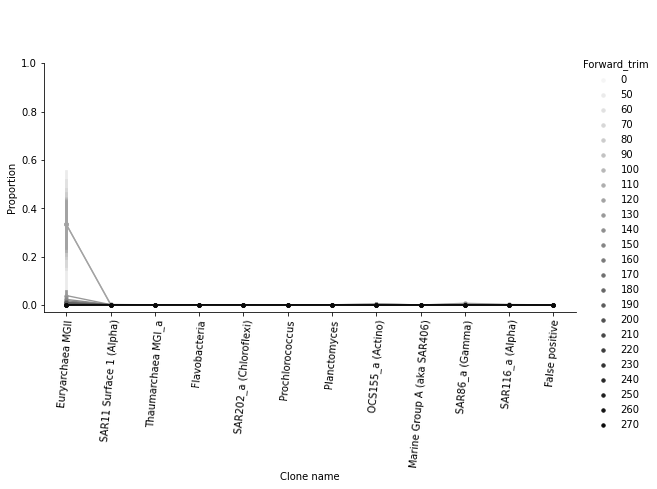

In [71]:
g = sns.catplot(x="Clone_name", y="ratio", hue="Forward_trim", kind="point", data=expobs_comp_copy, xticklabels=1, scale = 0.5#marker size 
                , palette='gray_r', size = 4, aspect = 2)
#g.set(ylim=(0, 1))
g.set(xlabel='Clone name', ylabel='Proportion', yticks=np.arange(0,1.02,0.2))
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=85)
#g.tight_layout()
g.savefig(f'outputs/{comm_id}{composition}{runnumber}obsratioline_angle85.png',
            bbox_inches = "tight")

#change step to 50 maybe pour avoir au total moins de lignes

In [75]:
#run 1 sample t test
#takes trimcombination in format F40R40
def ttst(trimcombination):
    compr_obs_exp = expected_silva_selected.merge(separated, how='outer', on='Taxon')
    compr_obs_exp = compr_obs_exp.rename(columns={'sample-id': 'Replicate'})
    compr_obs_exp=compr_obs_exp.fillna(0)
    compr_obs_exp["Clone_name"].replace({0: "False positive"}, inplace=True)
    df_with_groups = compr_obs_exp[compr_obs_exp.table_id == trimcombination]
    
    #add if empty, return message saying this trim length is bad!
    
    
    means = df_with_groups.groupby('Clone_name').mean()
    newsi=means[[composition+'_ratio_expected', 'ratio']].copy()
    newsi.sort_values(composition+'_ratio_expected', ascending = False)
    newsi['Difference'] = newsi[composition+'_ratio_expected'] / newsi['ratio']
    newsi
    
    # generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences between different treatments
    ax = sns.boxplot(x='ratio', y='Clone_name', data=df_with_groups).set(
    xlabel='Relative abundance', 
    ylabel='Group'
    )
    plt.show()

    
    groups = df_with_groups['Clone_name'].unique()
    results = []
    for group in groups:    
        arr = df_with_groups[(df_with_groups['Clone_name'] == group)]['ratio'].values  #Filter the dataframe. 
        results.append({'Clone_name': group,
                        'ratios': arr}) #Make a single "record" containing the table id, replicate, and ratio array.
        r_gr = pd.DataFrame.from_records(results)
    
    y = expected_silva_selected[composition+'_ratio_expected']
    for i in range(len(y[0:-1])):
        xi = r_gr.iloc[i]['ratios']
        yi = y[i]
        print(r_gr.iloc[i]['Clone_name'])
        print(stats.ttest_1samp(xi, yi))
        #but there are outliers
    return (r_gr, newsi)

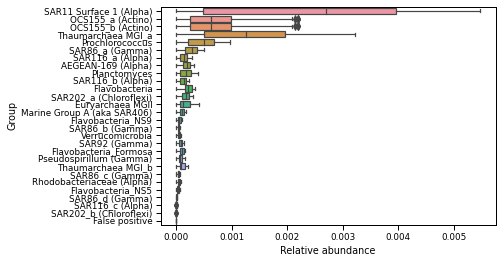

SAR11 Surface 1 (Alpha)
Ttest_1sampResult(statistic=-3205.853317736809, pvalue=0.0)
OCS155_a (Actino)
Ttest_1sampResult(statistic=-6349.357504507667, pvalue=0.0)
OCS155_b (Actino)
Ttest_1sampResult(statistic=-3608.904095901754, pvalue=0.0)
Thaumarchaea MGI_a
Ttest_1sampResult(statistic=-1514.4324578225883, pvalue=0.0)
Prochlorococcus
Ttest_1sampResult(statistic=-3494.208927949755, pvalue=0.0)
SAR86_a (Gamma)
Ttest_1sampResult(statistic=-4888.051058814427, pvalue=0.0)
SAR116_a (Alpha)
Ttest_1sampResult(statistic=-4023.162534772944, pvalue=0.0)
AEGEAN-169 (Alpha)
Ttest_1sampResult(statistic=-3663.6119516436484, pvalue=0.0)
Planctomyces
Ttest_1sampResult(statistic=-2266.248858996477, pvalue=0.0)
SAR116_b (Alpha)
Ttest_1sampResult(statistic=-3487.00761282932, pvalue=0.0)
Flavobacteria
Ttest_1sampResult(statistic=-2778.964236633173, pvalue=0.0)
SAR202_a (Chloroflexi)
Ttest_1sampResult(statistic=-2843.793783355825, pvalue=0.0)
Euryarchaea MGII
Ttest_1sampResult(statistic=-2052.749880943408, 

(                     Clone_name  \
 0       SAR11 Surface 1 (Alpha)   
 1             OCS155_a (Actino)   
 2             OCS155_b (Actino)   
 3            Thaumarchaea MGI_a   
 4               Prochlorococcus   
 5               SAR86_a (Gamma)   
 6              SAR116_a (Alpha)   
 7            AEGEAN-169 (Alpha)   
 8                  Planctomyces   
 9              SAR116_b (Alpha)   
 10                Flavobacteria   
 11       SAR202_a (Chloroflexi)   
 12             Euryarchaea MGII   
 13  Marine Group A (aka SAR406)   
 14            Flavobacteria_NS9   
 15              SAR86_b (Gamma)   
 16              Verrucomicrobia   
 17                SAR92 (Gamma)   
 18        Flavobacteria_Formosa   
 19      Pseudospirillum (Gamma)   
 20           Thaumarchaea MGI_b   
 21              SAR86_c (Gamma)   
 22    Rhodobacteriaceae (Alpha)   
 23            Flavobacteria_NS5   
 24              SAR86_d (Gamma)   
 25             SAR116_c (Alpha)   
 26       SAR202_b (Chlorofl

In [76]:
ttst('F220R220')

In [56]:
def thresholds():
    dic = {
        "Domain": f'{dest_dir}/TBD1/tax_comp.csv',
        "Phylum": f'{dest_dir}/TBD2/tax_comp.csv',
        "Class": f'{dest_dir}/TBD3/tax_comp.csv',
        "Order": f'{dest_dir}/TBD4/tax_comp.csv',
        "Family": f'{dest_dir}/TBD5/tax_comp.csv',
        "Genus": f'{dest_dir}/TBD6/tax_comp.csv',
        "Species": f'{dest_dir}/TBD7/tax_comp.csv'
    }
    thresholds = [1.0, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20, 0.15, 0.10, 0.05, 0]
    df = pd.DataFrame(columns=['Rank', *thresholds]) #* unpack the list and adds to list, **is for unpacking dictionaries
    #eg. d3 = {**d1, **d2} or l3 = [*l1, *l2]
    for key in dic.keys():
        #tohm, dest_dir = make_tbd_hm(comm, composition, runnumber, level='6')
        #tohm, bacaros_dm, agexp = make_tbd_hm(dic[key], expected_file) #input the value of each key from the dictionary
        tohm = pd.read_csv(dic[key], index_col=0)
        row ={'Rank': key} #make an empty dictionary
        for thresh in thresholds:
            pp = ((tohm[tohm > thresh].count().sum())/tohm.size)*100
            row[thresh] = pp
        df = df.append(row, ignore_index=True)
    
    newdf = df.set_index(['Rank'])
    newdf['Rank'] = newdf.index
    melted = newdf.melt('Rank', var_name='Thresholds', value_name='TD')
    melted[["Thresholds", "TD"]]=melted[["Thresholds", "TD"]].apply(pd.to_numeric)
    
    sns.set_context('paper')
    fig = plt.figure(figsize=(5,5))
    p = sns.lineplot(data=melted, x="Thresholds", y="TD", hue='Rank', legend = True)
    p.set(ylim=(0, 100))
    p.set(xlim=(0,1))
    p.set_xlabel("\u03B2 diversity") #, fontsize = 10)
    p.set_ylabel("Percentage of tables",)# fontsize = 10)
    #p.invert_xaxis()
    ax = p.get_figure()
    ax.savefig(f'outputs/thresholds{comm_id}_{composition}_{runnumber}_with_legend.png', format='png', dpi=600, bbox_inches="tight")
    return df

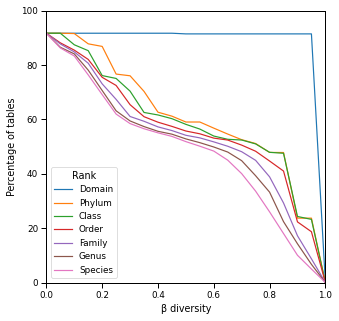

In [57]:
df = thresholds()

In [51]:
df

,Rank,1.0,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,...,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,0.05,0
0,Domain,0.0,90.957110,90.957110,90.957110,90.957110,90.957110,90.957110,90.957110,90.957110,...,91.690515,91.690515,91.690515,91.690515,91.690515,91.690515,91.690515,91.690515,91.690515,91.690515
1,Phylum,0.0,33.171169,33.171169,48.789957,49.049705,53.284817,53.515839,57.480813,57.787315,...,62.354293,64.785532,66.841818,76.373951,78.128013,86.801450,88.804259,90.974528,91.690515,91.690515
2,Class,0.0,32.021862,37.914164,48.459925,49.894344,52.625363,53.583985,54.071394,56.448239,...,61.458010,63.874582,65.066060,66.880322,76.141095,77.470393,85.426926,88.594932,91.661790,91.690515
3,Order,0.0,35.679722,38.188886,45.158989,49.783416,51.802115,52.818493,53.798812,55.395802,...,59.955446,60.832171,63.939366,65.266830,72.664447,76.173793,83.513043,85.651226,89.105261,91.690515
4,Family,0.0,29.488251,36.620620,43.795465,47.747910,49.657820,51.939934,52.720094,54.523050,...,58.467549,59.780651,62.727719,63.938755,70.566602,75.350851,78.128013,84.457914,88.832373,91.690515
5,Genus,0.0,24.049438,32.311251,39.889775,43.809522,47.385791,49.759275,51.979049,53.471835,...,57.586240,58.669541,61.342193,63.019247,67.730156,71.943571,77.084743,83.959504,86.648657,91.690515
6,Species,0.0,11.155862,22.434723,33.616102,39.379753,43.864833,46.981807,50.029413,52.017858,...,56.775216,58.008254,60.293118,62.403798,65.801910,71.357457,76.942646,83.584856,86.478752,91.690515


In [68]:
against_exp.sort_values('expected') #get top value for TBD

,sample_name,expected,Forward_trim,Reverse_trim
315,46F100R90,0.103448,100,90
109,46F130R120,0.103448,130,120
256,46F60R130,0.103448,60,130
255,46F70R130,0.103448,70,130
254,46F190R80,0.103448,190,80
...,...,...,...,...
99,46F160R260,0.983051,160,260
163,46F130R260,0.983051,130,260
95,46F220R260,0.983051,220,260
183,46F190R260,0.983051,190,260


In [177]:
goodscores = against_exp.loc[(against_exp['expected'] >= 0.90)]

NameError: name 'against_exp' is not defined

In [79]:
goodscores.sort_values('Reverse_trim')

,sample_name,expected,Forward_trim,Reverse_trim
299,46F270R210,0.920635,270,210
1,46F270R220,0.920635,270,220
294,46F230R230,0.920635,230,230
72,46F260R230,0.920635,260,230
73,46F270R230,0.920635,270,230
171,46F240R230,0.920635,240,230
170,46F250R230,0.920635,250,230
292,46F0R240,0.920635,280,240
279,46F250R240,0.920635,250,240
278,46F240R240,0.920635,240,240


In [57]:
above9r2 = tohm[tohm > 0.85 ].count(axis=1) #get range of forward trimming thats best

In [58]:
above9r2

Forward_trim
50       0
60       0
70       0
80       0
90       0
100      0
110      0
120      1
130      2
140      3
150      4
160      4
170      4
180      4
190      4
200      4
210      4
220      4
230      5
240      5
250      8
260      8
270     16
full     8
dtype: int64

In [59]:
above9r2.quantile([0.25,0.5,0.75])

0.25    0.00
0.50    4.00
0.75    4.25
dtype: float64

In [60]:
bestfs = tohm.loc[[230,240,250,260,270, 'full'],:]
bestfs

Reverse_trim,30,40,50,60,70,80,90,100,110,120,...,200,210,220,230,240,250,260,270,280,full
Forward_trim,,,,,,,,,,,,,,,,,,,,,
230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.783784,0.773333,0.816901,0.920635,0.920635,0.966667,0.983051,0.898305,0.237288,NaN
240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.783784,0.773333,0.816901,0.920635,0.920635,0.966667,0.898305,0.898305,0.237288,NaN
250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.865672,0.852941,0.852941,0.920635,0.920635,0.966667,0.898305,0.898305,0.237288,NaN
260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.206897,...,0.865672,0.852941,0.852941,0.920635,0.920635,0.966667,0.898305,0.898305,0.237288,NaN
270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.482759,0.852941,...,0.892308,0.920635,0.920635,0.920635,0.920635,0.966667,0.898305,0.898305,0.237288,NaN
full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.852941,...,0.773333,0.773333,0.773333,0.773333,0.920635,0.966667,0.898305,0.796610,0.237288,0.773333


In [61]:
bestfsrs = bestfs[bestfs > 0.85 ].count()
bestfsrs

Reverse_trim
30      0
40      0
50      0
60      0
70      0
80      0
90      0
100     0
110     0
120     2
130     2
140     2
150     2
160     2
170     1
180     1
190     1
200     3
210     3
220     3
230     5
240     6
250     6
260     6
270     5
280     0
full    0
dtype: int64

In [62]:
bestfsrs.quantile([0.25,0.5,0.75])

0.25    0.0
0.50    1.0
0.75    3.0
dtype: float64

__get_fig_per_group__ makes a heatmap of the observed against expected relative abundances for given group names and colors ratios above the expected in blues, and below the expected in reds.

In [186]:
def get_fig_per_group(groupname, expectedratio, duplicate='mean'):
    neoceratium = separated[separated['Taxon'].str.contains(groupname)]
    neoceratium = neoceratium[neoceratium.feature_frequency !=0]
    neoceratium.rename(columns = {'sample-id':'sample_id'}, inplace=True)
    if duplicate!='mean':
        neoceratiumR1 = neoceratium[neoceratium.sample_id == 'R46-'+comm_id+'-'+duplicate]
    else:
        neoceratiumR1 = neoceratium.groupby(['Forward_trim','Reverse_trim'])[['ratio']].mean()
        neoceratiumR1 = neoceratiumR1.reset_index()
    neoceratiumR1["Forward_trim"] = pd.to_numeric(neoceratiumR1["Forward_trim"])
    neoceratiumR1["Reverse_trim"] = pd.to_numeric(neoceratiumR1["Reverse_trim"])
    neoceratiumR1["Forward_trim"].replace({0: 280}, inplace=True)
    neoceratiumR1["Reverse_trim"].replace({0: 290}, inplace=True)
    neoceratiumR1merged = neoceratiumR1.groupby(['Forward_trim','Reverse_trim'])[['ratio']].mean()
    neoceratiumR1merged = neoceratiumR1merged.reset_index()
    tohm = neoceratiumR1merged.pivot("Forward_trim", "Reverse_trim", "ratio")
    tohm.rename({280: 'full'}, axis=0, inplace=True)
    tohm.rename({290: 'full'}, axis=1, inplace=True)
    ax = sns.heatmap(tohm, cmap="Oranges_r")#, mask= (tohm < (expectedratio-(0.0005*expectedratio))) & (tohm > (expectedratio+(0.0005*expectedratio)))) #cmap=sns.color_palette("hls", 90)
    ax = sns.heatmap(tohm, mask=tohm <= expectedratio, cmap=sns.color_palette("GnBu", 5)) #square=True, annot=False, vmin=0, vmax=1, cbar=False, ax=ax)
    #ax = sns.heatmap(tohm, mask=tohm >= expectedratio, cmap=sns.color_palette("Oranges_r", 5)) #square=True, annot=False, vmin=0, vmax=1, cbar=False, ax=ax)
    ax.invert_yaxis()
    plt.figure(figsize=(12,12))
    ax.set(xlabel='Reverse trim length', ylabel='Forward trim length')
    fig = ax.get_figure()
    fig.savefig('ratio'+groupname+'.png', bbox_inches = "tight")
    return neoceratiumR1merged

In [187]:
get_fig_per_group('False positive', 0)

ValueError: zero-size array to reduction operation fmin which has no identity

__ttst__ runs one sample t tests between each taxonomic groups observed against expected relative abundances, and plots the results in a boxplot for a single trimming combination

In [387]:
#run 1 sample t test
#takes trimcombination in format F40R40
def ttst(trimcombination):
    compr_obs_exp = expstagg.merge(separated, how='outer', on='Taxon')
    compr_obs_exp = compr_obs_exp.rename(columns={'sample-id': 'Replicate'})
    compr_obs_exp=compr_obs_exp.fillna(0)
    compr_obs_exp["group"].replace({0: "False positive"}, inplace=True)
    df_with_groups = compr_obs_exp[compr_obs_exp.table_id == trimcombination]
    
    
    means = df_with_groups.groupby('group').mean()
    newsi=means[['expected_ratio', 'ratio']].copy()
    newsi.sort_values('expected_ratio', ascending = False)
    newsi['Difference'] = newsi['expected_ratio'] / newsi['ratio']
    newsi
    
    # generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences between different treatments
    ax = sns.boxplot(x='ratio', y='group', data=df_with_groups).set(
    xlabel='Relative abundance', 
    ylabel='Group'
    )
    #ax.tick_params(axis='x', labelrotation=90)
    plt.show()
    
    results = []
    for group in groups:    
        arr = df_with_groups[(df_with_groups['group'] == group)]['ratio'].values  #Filter the dataframe. 
        results.append({'group': group,
                        'ratios': arr}) #Make a single "record" containing the table id, replicate, and ratio array.
        r_gr = pd.DataFrame.from_records(results)
    
    y = expstagg['expected_ratio']
    for i in range(len(y[0:-1])):
        xi = r_gr.iloc[i]['ratios']
        yi = y[i]
        print(r_gr.iloc[i]['group'])
        print(stats.ttest_1samp(xi, yi))
        #but there are outliers
    return (r_gr, newsi)

## Run analyses and make figures

In [410]:
def get_figures(community, composition, runnumber, R='all', F='all',level=7):
    
    df, comm, comm_id = consolidate_tables(community) #concat all feature tables and their pipeline parameters
    merged = merge_metadata() #add the metadata
    composition, runnumber, R, F, separated_taxonomies, separated_dic, files, tax, separated, taxos = pick_metadata(composition, runnumber)
    pick_taxonomies() #rename the taxonomy tsv files for taxonomic beta diversity
    make_fasta() #extract the sequences
    make_tbd_hm(level=7) #make TBD heatmap
    ## add function to find best trim length ranges (white box)
    ## add table of thresholds + line plot
    r2_plot()
    ##run t tests for best TBD and best r2, make boxplot
    #get_fig_per_group()
    ## get sequence comparison
    ## get files for import to evolview --tree, abundance table, branch coloring and expected ratios
    
    return

Found all tables
Success.
Set up manifest ...
Set up metadata ...
Saved merged_asvs_metadata.tsv
Appended all taxonomies to taxos


/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


Taxonomies already split
Saved selected sequences as 02-PROKs/all_seqs/RallFall46Staggered.fasta
Bacaros Beta is already cloned.
in-silico-mocks/02-PROKs/Staggered/7fee7113-8e8a-459b-ae32-6d8381294d5c/data/taxonomy.tsv was moved.
Saved all taxonomies list as tax_comp.txt
BTD Already ran


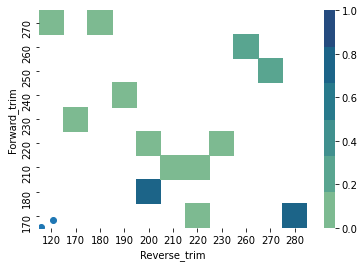

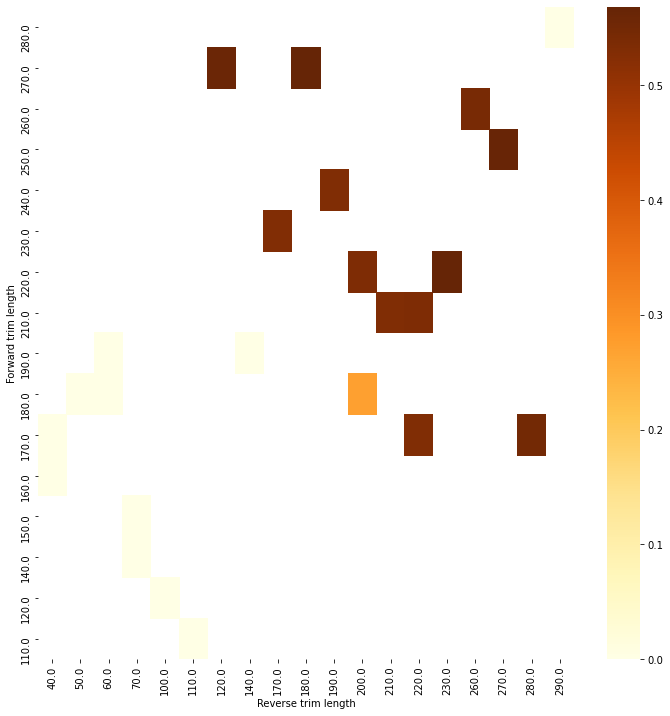

<Figure size 864x864 with 0 Axes>

In [411]:
get_figures('18S', 'Staggered', '46')